<a href="https://colab.research.google.com/github/trevor-c-CU-MSDS/assignments/blob/main/notebook629c306c8b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'learn-ai-bbc:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F13351%2F324297%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240227%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240227T065120Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D59545edc8e381ed1c123c8d44976b7aa809a9c6ba5b78daa0499e9695222f33ade2854434b21f5cf8f205c5b20a517ad71bcd3d7357a2613e67f8a4353950e4dde880f08e2edff7bfaccfce6f48b4ccdfb6a66f93a81988bae8d80936c193aebcbaeae5862407f17bdd0390092e5d47dbb97cdf27dce928f2f72d0b014b9bd6a3adb9bb012175104fba885b0394e3ba400dade40d65d09d354bc69b55dfd35e5990d9a586cf8337e970f157478c9d32b5f716f1dc18cfe010a031b901438cc44fb5dad41cd5b2e838b693fb4b92e297cd42c7a39406d37f6e8decbb68ad0df9ca19efd31e67326d227282cc4061a2b347f38e497c00c200531c1cb0413bcb9f6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1936538 bytes downloaded
Downloaded and uncompressed: learn-ai-bbc
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [ ]:
df_train = pd.read_csv(files[0])
df_test = pd.read_csv(files[2])

print('---------------Quick high-level inspection of our training dataset:---------------')
print(df_train.info())
print(df_train.head())
print('\n')

print('---------------Quick high-level inspection of our testing dataset:---------------')
print(df_test.info())
print(df_test.head())

print('\n')

print('---------------Quick high-level inspection of "New Sample Solution":---------------')
df_soln = pd.read_csv(files[1])
print(df_soln.info())
print(df_soln.head())

matches = sum(df_soln.iloc[:,0] == df_test.iloc[:,0])
print('\n')
print('{a} out of {b} entries match between the solutions and test dataset.'.format(a=matches, b=np.shape(df_test)[0]))

---------------Quick high-level inspection of our training dataset:---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


---------------Quick high-level inspection of our testing dataset:---------------
<class 'pandas.core.frame.DataFr

From 1st glance, we see that the training set is almost twice as big as the testing set. However, it's also important to notice that the training dataset has an extra column called "Category" which probably serves as the labels: sport, politics, tech, entertainment, and business.

If we load the "New Sample Solutions" dataset, we can see that it has the same dimensions as the testing dataset. Furthermore, we can confirm that the New Sample Solutions holds the true labels for our testing data.

0 Text entries with null values.
0 Category entries with null values. 

ArticleId    1490
Text         1440
Category        5
dtype: int64
But there are 50 Text entries with duplicated values. 

---------------Cleaning up dataset---------------

ArticleId    1440
Text         1440
Category        5
dtype: int64
After cleanup, 0 Text entries with duplicated values. 

Distribution of Categories in our dataset.


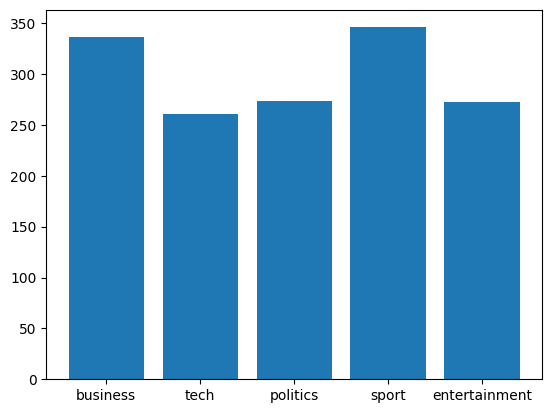

In [ ]:
na_text = sum(df_train['Text'].isnull())
print('{} Text entries with null values.'.format(na_text))

na_cat = sum(df_train['Category'].isnull())
print('{} Category entries with null values.'.format(na_cat), '\n')

print(df_train.nunique())
dup_text = sum(df_train['Text'].duplicated())
print('But there are {} Text entries with duplicated values.'.format(dup_text), '\n')


print('---------------Cleaning up dataset---------------\n')

df_clean = df_train.drop_duplicates(subset=['Text'])
print(df_clean.nunique())
dup_text = sum(df_clean['Text'].duplicated())
print('After cleanup, {} Text entries with duplicated values.'.format(dup_text), '\n')

lab_count = list(df_train['Category'].unique())
lab = {}
for i in lab_count:
    lab[i] = sum(df_train['Category'] == i)
plt.bar(lab.keys(), lab.values())
print('Distribution of Categories in our dataset.')

At first, it would appear as if our dataset was perfect because there aren't any rows/columns with missing values. However upon further inspection, there are actually quite a few duplicated values that are unnecessary. After removing the duplicates we can then visualize our dataset accurately.

The categories are fairly uniform in occurrences with albiet with descrepencies. For example, Sports has the most amount of entries versus Tech which has the least. Theoretically, this could mean that Sports can be more accurately classified simply due to more training opportunities. However, all categories have over 250 datapoints each to train from which is a healthy amount.

In [ ]:
# Adapted from the sklearn example: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.show()

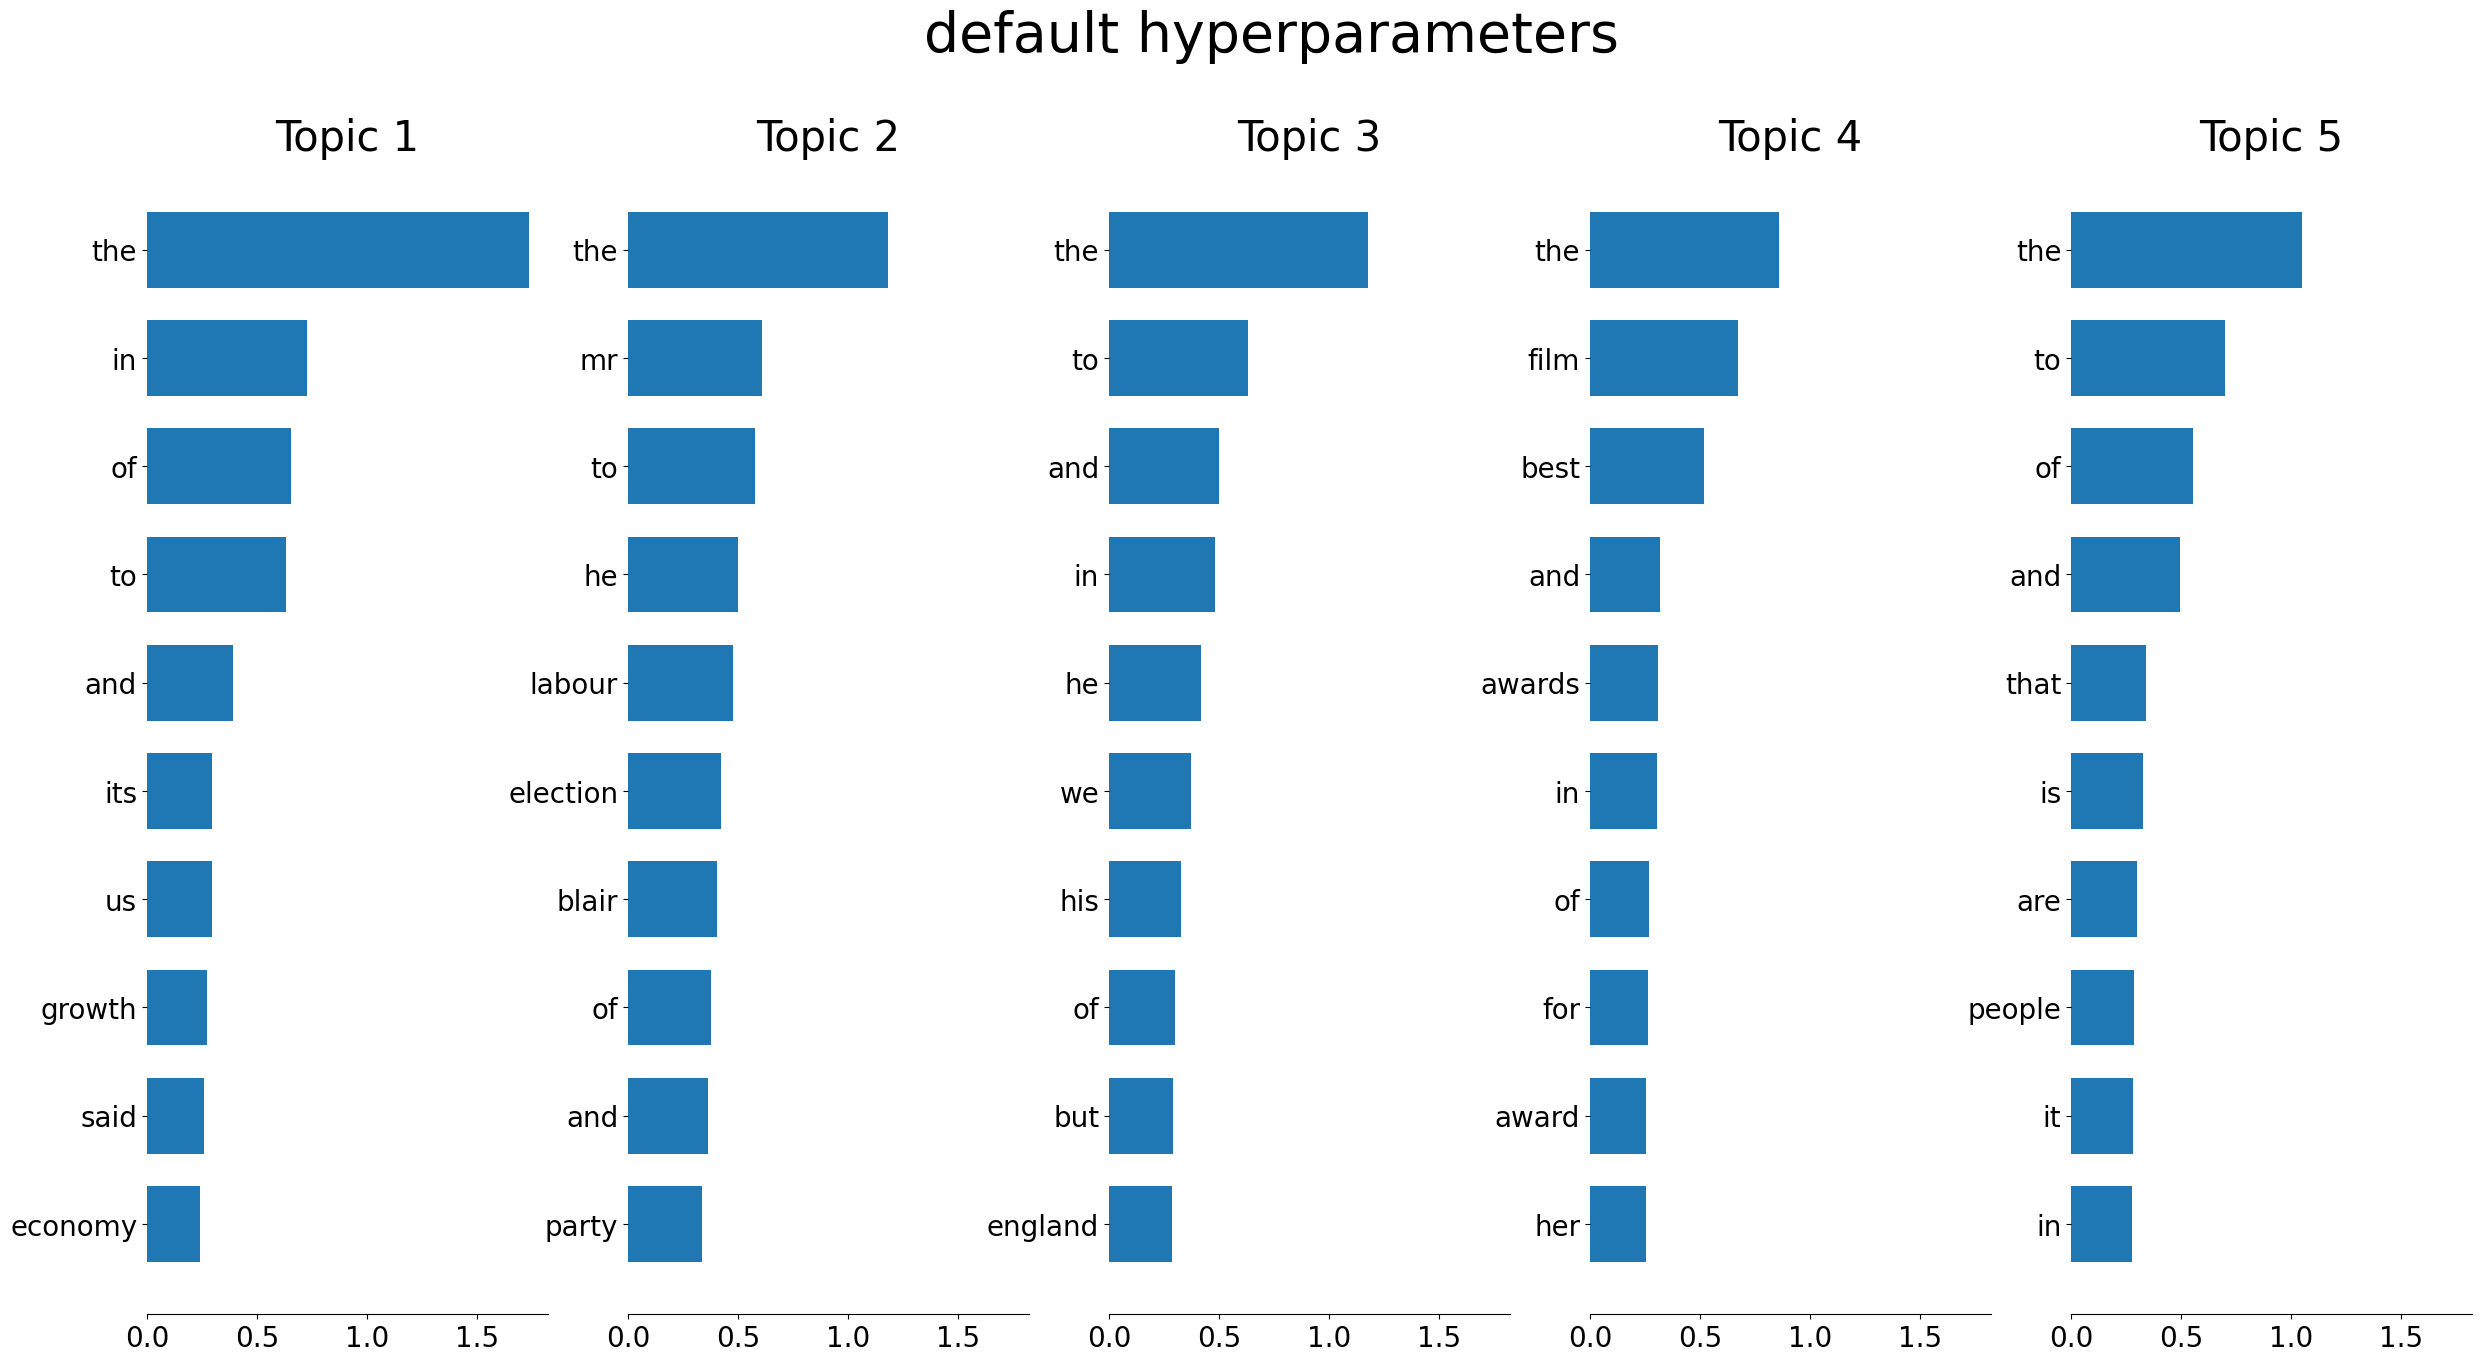

[[306   0  12   2  15]
 [ 14 188   5  20  36]
 [ 24   0 206   2  34]
 [  3   2   0 336   1]
 [  7   2   1   2 222]]
The accuracy of our model is 87.36111111111111%.


In [ ]:
# NMF model fitted with default parameters

vectorizer = TfidfVectorizer()
v = vectorizer.fit(df_clean['Text'])
bagofwords = vectorizer.transform(df_clean['Text'])

model_nmf = NMF(n_components=5, init='nndsvda', solver='cd', beta_loss='frobenius').fit(bagofwords)

names = vectorizer.get_feature_names_out()

plot_top_words(model=model_nmf, feature_names=names, n_top_words=10, title='default hyperparameters')

yp = model_nmf.transform(bagofwords)
yp = np.argmax(yp, axis=1)

labels = {0:'business', 1:'politics', 2:'sport', 3:'entertainment', 4:'tech'}
yp_labeled = [labels.get(value) for value in yp]

print(confusion_matrix(y_true=df_clean['Category'], y_pred=yp_labeled))
print('The accuracy of our model is {}%.'.format(100*accuracy_score(y_true=df_clean['Category'], y_pred=yp_labeled)))

Here we take our 1st pass at modeling our training data. The first requirement is to transform our Text data (which is essentially a big string) into something meaningful (numeric). We do this by utilizing the TfidVectorizer() from sklearn which finds unique words in the text and determines how frequent it pops up for that given text document. Upon completion, a mxn matrix is created where m represents each document, and n represents each unique word. This process is generically called vectorization, but more specifically bag of words.

After creating our bag of words, we fit a Non-negative Matrix Factorization (NMF) model. An NMF model's objective is to deconstruct a complex dataset into 2 matrices which can then be used for predicting new data.

However, when applying the bag of words and NMF model, we get an accuracy of 87.36%.

In [ ]:
bagofwords = v.transform(df_test['Text'])

yp_test = model_nmf.transform(bagofwords)
yp_test = np.argmax(yp_test, axis=1)
yp_labeled = [labels.get(value) for value in yp_test]

In [ ]:
# submission = pd.DataFrame({
#     "ArticleID": df_test['ArticleId'],
#     "Category": yp_labeled
# })
# submission.to_csv('subission.csv', index=False)


# Submission obtains 0.88163 score

By submitting the trained algorithm with the default parameters above, we get a 88.163%. This is a very good test score! However, by plotting out what is being modeled, we see that a lot of words overlap and are not specific (e.g. 'the', 'to', and 'in'). We can exclude these trivial words by refining the hyperparameters in our vectorization.

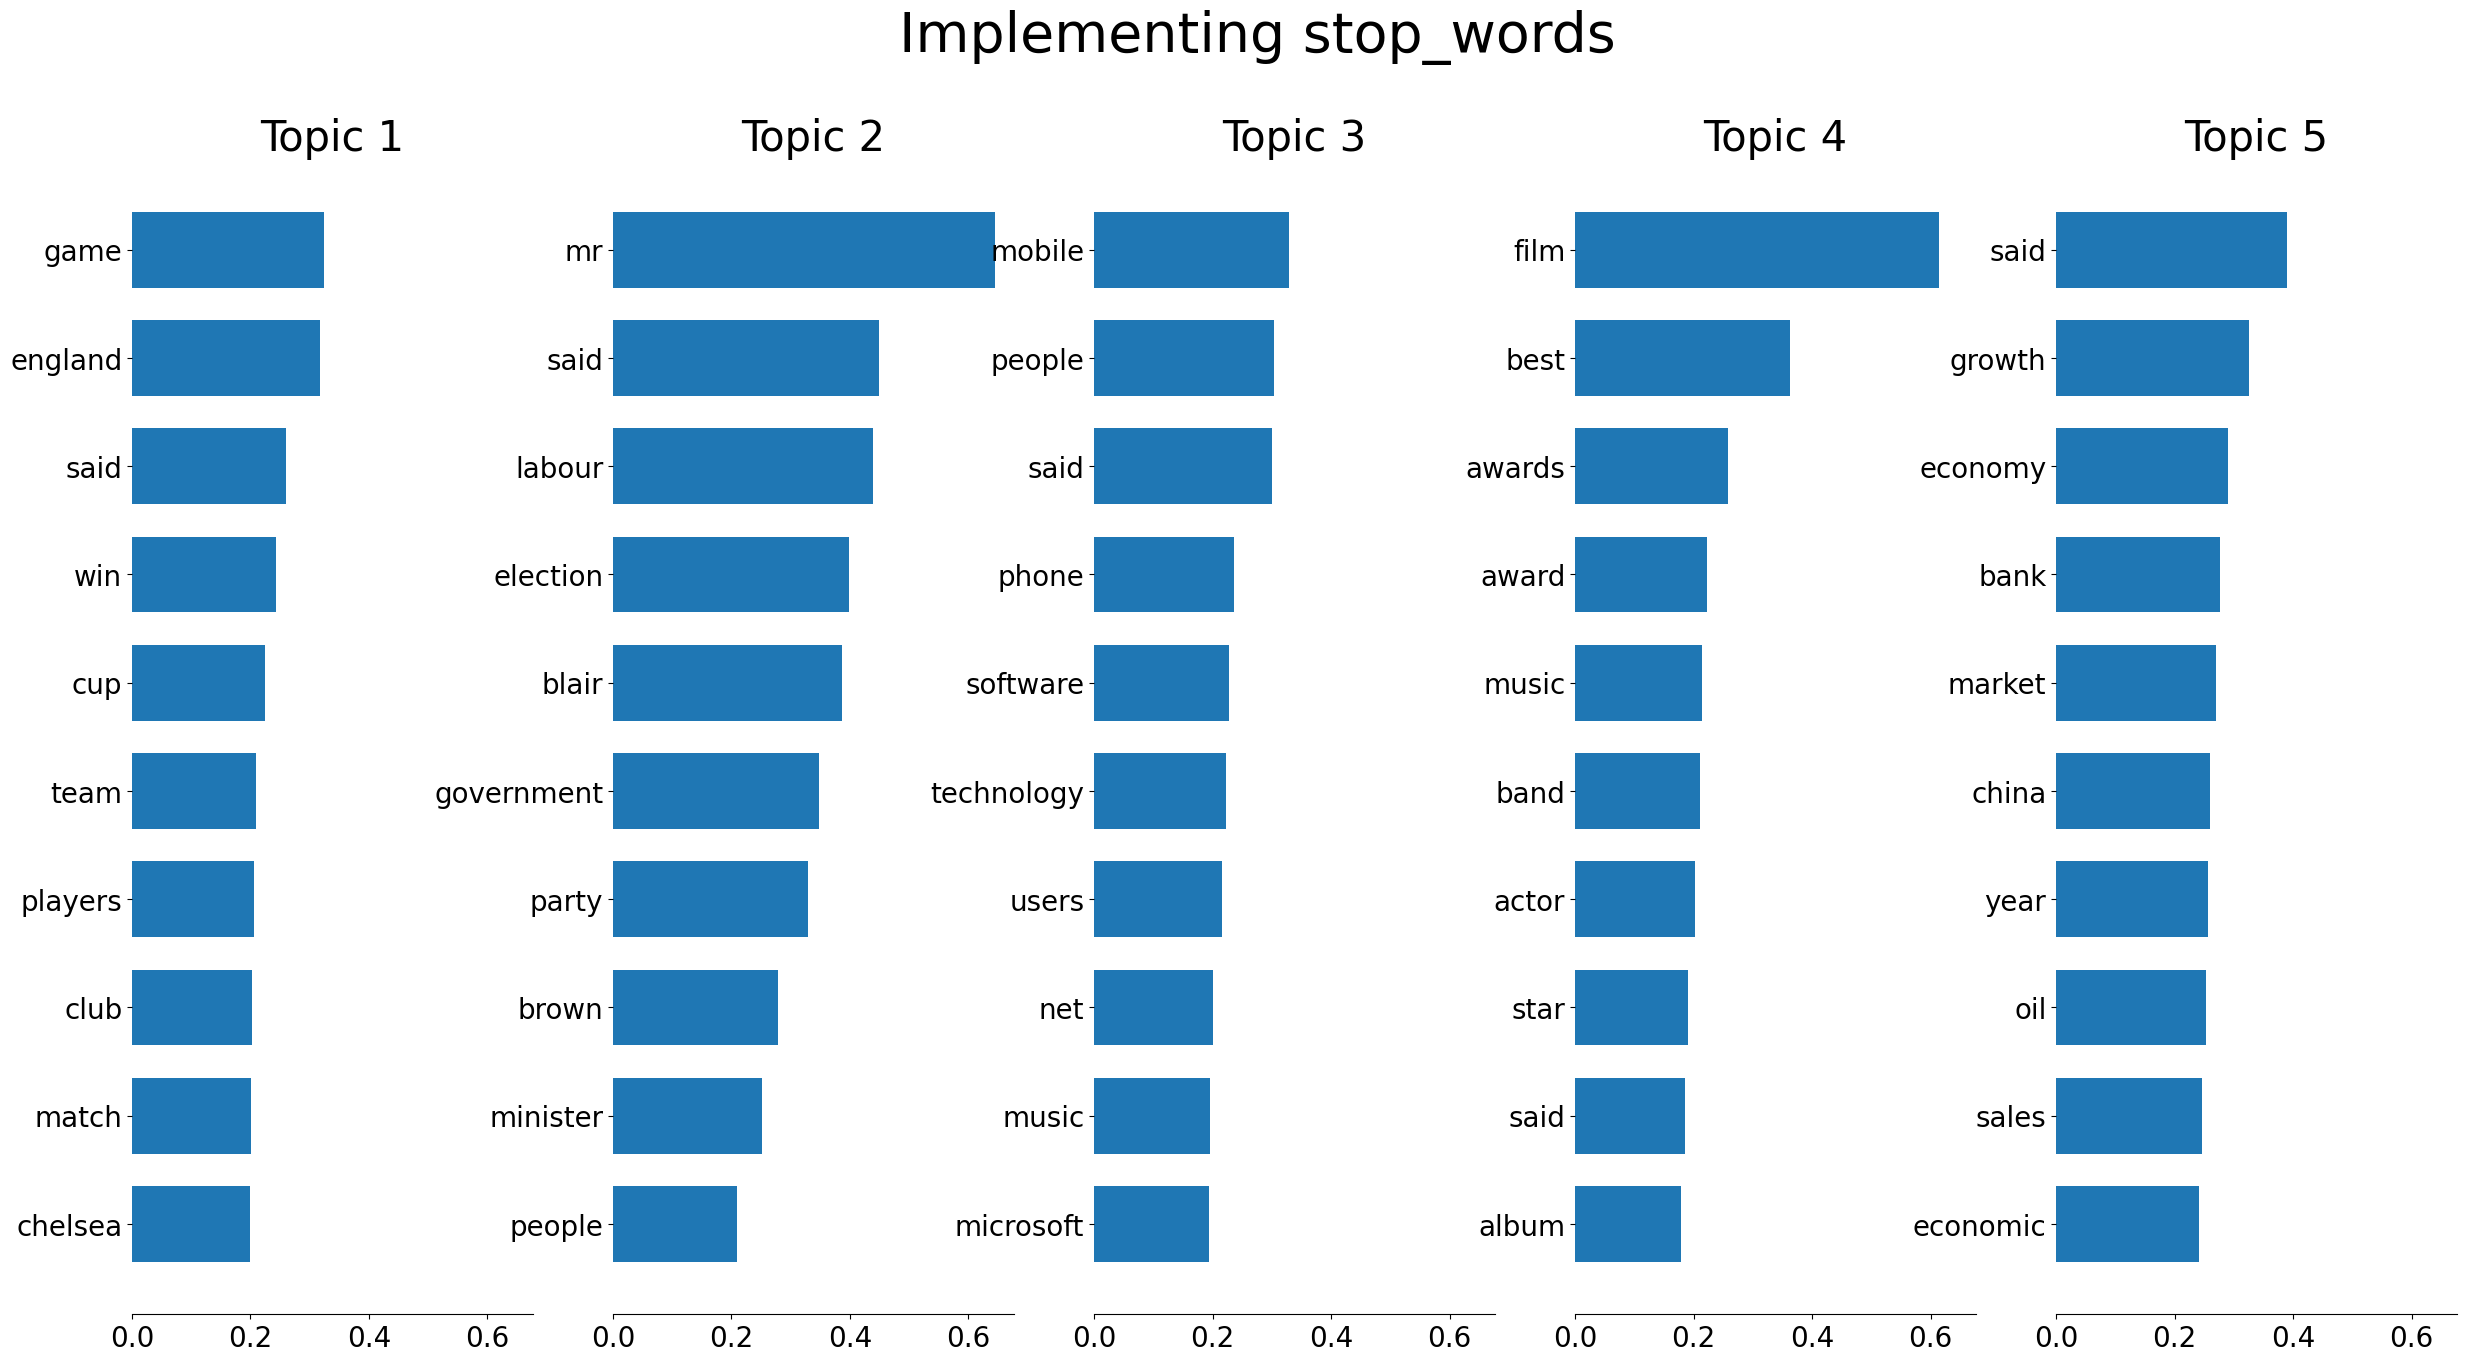

[[270   1  13   8  43]
 [  2 243   1  10   7]
 [  5   2 249   9   1]
 [  0   2   0 340   0]
 [  0   4   1   8 221]]
Now our new accuracy  is 91.875%.


In [ ]:
# Improving the vectorizer to exclude "trivial" words
# Also we will change the solver to kullback-leibler

vectorizer = TfidfVectorizer(stop_words='english')
v = vectorizer.fit(df_clean['Text'])
bagofwords = v.transform(df_clean['Text'])

nmf = NMF(n_components=5, init='nndsvda', solver='mu', beta_loss='kullback-leibler')

model_nmf = nmf.fit(bagofwords)
names = vectorizer.get_feature_names_out()

plot_top_words(model=model_nmf, feature_names=names, n_top_words=10, title='Implementing stop_words')

yp_train = model_nmf.transform(bagofwords)
yp_train = np.argmax(yp_train, axis=1)

labels = {0:'sport', 1:'politics', 2:'tech', 3:'entertainment', 4:'business'}
yp_labeled = [labels.get(value) for value in yp_train]

print(confusion_matrix(y_true=df_clean['Category'], y_pred=yp_labeled))
print('Now our new accuracy  is {}%.'.format(100*accuracy_score(y_true=df_clean['Category'], y_pred=yp_labeled)))

Now that we have excluded the nonspecific words, we get an even better accuracy score of 91.81%, jumping up nearly 5%! We can now use this better trained model to predict the labels on our testing dataset.

In [ ]:
bagofwords = v.transform(df_test['Text'])

yp_test = model_nmf.transform(bagofwords)
yp_test = np.argmax(yp_test, axis=1)
yp_labeled = [labels.get(value) for value in yp_test]

In [ ]:
# submission = pd.DataFrame({
#     "ArticleID": df_test['ArticleId'],
#     "Category": yp_labeled
# })
# submission.to_csv('subission.csv', index=False)

# Submission obtains 0.94693 score


After submission, the accuracy was 94.693% which is exceptional-- an increase of 6.5%! This is a worthwhile change especially given that the testing dataset increased by a mere 0.8%. The difference between the default frobenius (also knowon as L1) is that the frobenius method is based off of a laplace distribution, whereas the kullback-leibler method follows a poisson distribution. The kullback-leibler method also requires the solver to be 'mu' which stands for multiplicative update solver (the other option being 'cd' for coordinate descent). The frobenius method can utilize either approach.

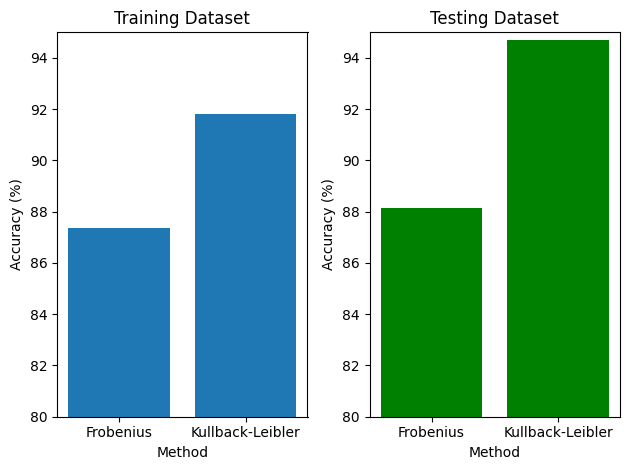

In [ ]:
plt.subplot(1,2,1)
plt.bar(height=[87.361, 91.806], x=['Frobenius','Kullback-Leibler'])
plt.title('Training Dataset')
plt.ylabel('Accuracy (%)')
plt.xlabel('Method')
plt.ylim(80, 95)

plt.subplot(1,2,2)
plt.bar(height=[88.163, 94.693], x=['Frobenius','Kullback-Leibler'], color='green')
plt.title('Testing Dataset')
plt.ylabel('Accuracy (%)')
plt.xlabel('Method')
plt.ylim(80, 95)

plt.tight_layout()

Now just to check, we can compare NMF-- which is an unsupervised algorithm-- to a supervised algorithm such as RandomForest.

Test accuracy of Random Forest with 1 depths: 0.5645833333333333
Test accuracy of Random Forest with 2 depths: 0.6854166666666667
Test accuracy of Random Forest with 3 depths: 0.8180555555555555
Test accuracy of Random Forest with 4 depths: 0.8875
Test accuracy of Random Forest with 5 depths: 0.9222222222222223
Test accuracy of Random Forest with 6 depths: 0.9506944444444444
Test accuracy of Random Forest with 7 depths: 0.9611111111111111
Test accuracy of Random Forest with 8 depths: 0.9708333333333333
Test accuracy of Random Forest with 9 depths: 0.9777777777777777
[[335   0   0   0   0]
 [  3 251   0   9   0]
 [  5   0 257   4   0]
 [  0   0   0 342   0]
 [  6   0   0   5 223]]


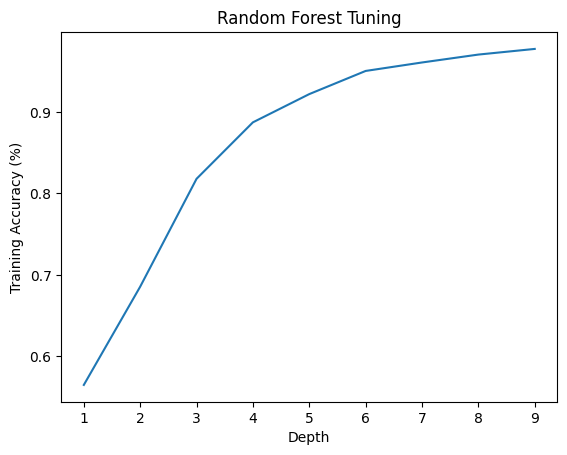

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
v = vectorizer.fit(df_clean['Text'])
bagofwords = v.transform(df_clean['Text'])


depths = [i for i in range(1,10)]
depth_tracker = {}
for d in depths:
    rf = RandomForestClassifier(n_estimators=200, max_depth=d, random_state=0)
    rf.fit(bagofwords, df_clean['Category'])
    y_pred = rf.predict(bagofwords)
    depth_tracker[d] = accuracy_score(y_true=df_clean['Category'], y_pred=y_pred)
    print('Test accuracy of Random Forest with {} depths: {}'.format(d, accuracy_score(y_true=df_clean['Category'], y_pred=y_pred)))


plt.plot(depth_tracker.keys(), depth_tracker.values())
plt.title('Random Forest Tuning')
plt.xlabel('Depth')
plt.ylabel('Training Accuracy (%)')
rf_best = RandomForestClassifier(n_estimators=200, max_depth=9, random_state=0)
rf_best.fit(bagofwords, df_clean['Category'])
print(confusion_matrix(y_true=df_clean['Category'], y_pred=rf_best.predict(bagofwords)))

bagofwords_test = v.transform(df_test['Text'])
y_pred_rf = rf_best.predict(bagofwords_test)

In [ ]:
# submission = pd.DataFrame({
#     "ArticleID": df_test['ArticleId'],
#     "Category": y_pred_rf
# })
# submission.to_csv('subission.csv', index=False)

# Submission obtains 0.93741 score

By using Random Foreset, a supervised approach, we get an accuracy of 93.741%. This is also very high, but not higher than our best model using NMF. However, an interesting thing is that the random forest's accuracy for the chosen depth 9 is 97.78%. Through iterating depths between 1-9, it's clear to see that the training accuracy increases but the return on the testing set does not increase that much. Therefore, there could be overfitting and the cost of increasing the random forest depth might not be worthwhile.

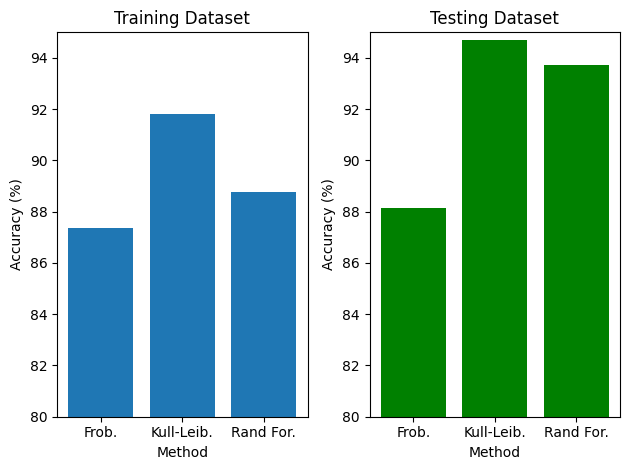

In [ ]:
plt.subplot(1,2,1)
plt.bar(height=[87.361, 91.806, 88.75], x=['Frob.','Kull-Leib.', 'Rand For.'])
plt.title('Training Dataset')
plt.ylabel('Accuracy (%)')
plt.xlabel('Method')
plt.ylim(80, 95)

plt.subplot(1,2,2)
plt.bar(height=[88.163, 94.693, 93.741], x=['Frob.','Kull-Leib.', 'Rand For.'], color='green')
plt.title('Testing Dataset')
plt.ylabel('Accuracy (%)')
plt.xlabel('Method')
plt.ylim(80, 95)

plt.tight_layout()

In [ ]:
test = pd.read_csv('/test.csv')
movies = pd.read_csv('/movies.csv')
train = pd.read_csv('/train.csv')
users = pd.read_csv('/users.csv')

train_ratings = train.pivot(index='uID', columns='mID', values='rating')
impute = np.isnan(train_ratings)
train_ratings[impute] = 0

nmf = NMF(n_components=5, init='nndsvda',
          solver='mu', beta_loss='kullback-leibler')
W, H = nmf.fit_transform(train_ratings), nmf.components_
yhat = W @ H

results = pd.DataFrame(data = yhat,
                  index = train_ratings.index.values,
                  columns = train_ratings.columns.values)
results['uID'] = pred_df.index.values
results = pd.melt(results, id_vars=['uID'], var_name='mID', value_name='yhat')
ans = results.merge(test, on=['uID', 'mID'])

rmse = np.sqrt(mse(ans['rating'].values, ans['yhat'].values))
print('NMF produces an RMSE of: ', rmse)

NMF produces an RMSE of:  3.0195120107634463


The RMSE from our Week 3 model produces a value of around 1.3 and 1.0 for predict_everything_to_3 and predict_to_user_average, respectively, which are both smaller than the performance of NMF. RMSE (which stands for Root Mean Square Error) is a way to track performance of a model, and does so by essentially reporting the average error. Rather than giving an explicit interpretation, its meaning is best determined by comparing with other models. Therefore, compared to the Week 3 models, NMF is not on par.

The reason for this is that it could largely be due to the way the N/A were dealt. In Week 3 we used different methods for imputation which produced different results. Here in the NMF model, we simply casted the missing values as 0. This could have unintentionally skewed and misled our data and may have contributed to the increased RMSE.
